In [1]:
from networkx import Graph
import networkx as nx
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit


class QuantumGraphColoring:

    def __init__(self, num_vertex: int, edges_list: list[tuple[int]]) -> None:
        self.num_vertex = num_vertex
        self.edges_list = edges_list

        self.num_edges = len(self.edges_list)
        self.num_qubits = (2 * self.num_vertex) + self.num_edges + 1

        print(f"Number of Vertices in the Graph: {self.num_vertex}")
        print(f"Number of Edges in the Graph: {self.num_edges}")
        print(f"Number of Qubits for Quantum Circuit: {self.num_qubits}")

        self.__aux_qubit_idx = self.num_qubits - 1
        print(f"Auxillary Qubit Index: {self.__aux_qubit_idx}\n")

    def display_graph(self):
        G = Graph()

        G.add_nodes_from(list(range(self.num_vertex)))
        G.add_edges_from(self.edges_list)

        nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=True)

    def initialize_quantum_circuit(self, measure_all: bool = True) -> QuantumCircuit:
        quantum_registers = QuantumRegister(self.num_qubits, 'q')

        self.ancilla_qubits_list = quantum_registers[-(self.num_edges + 1):-1]
        self.vertex_qubits_tuple = [(quantum_registers[i], quantum_registers[i + 1])
                                    for i in range(0, len(range(self.num_vertex * 2)), 2)]
        self.aux_qubit = quantum_registers[self.__aux_qubit_idx]

        print(f"Anilla Qubits:")
        for idx, qubit in enumerate(self.ancilla_qubits_list):
            print(f"\tNode {idx}: {qubit}\n")

        print(f"Vertex Qubits:")
        for idx, qubit_tuple in enumerate(self.vertex_qubits_tuple):
            print(f"\tNode {idx}: {qubit_tuple}")

        if measure_all:
            classical_registers = ClassicalRegister(self.num_qubits, 'c')
        else:
            classical_registers = ClassicalRegister((self.num_vertex * 2), 'c')

        self.circuit = QuantumCircuit(quantum_registers, classical_registers)

        return self.circuit

In [2]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.quantumregister import Qubit
from qiskit.quantum_info import Statevector
from IPython.display import display

import numpy as np

class GroverOracle:

    def __init__(self, vertex_qubits: list[tuple[Qubit]],
                 edges_list: list[tuple[int]],
                 ancilla_qubits: list[Qubit],
                 auxillary_qubit: Qubit) -> None:

        self.vertex_qubits_tuple = vertex_qubits
        self.edges_list = edges_list
        self.ancilla_qubits_list = ancilla_qubits
        self.aux_qubit = auxillary_qubit

    def __similarity_operator(self, circuit: QuantumCircuit, graph_node_1: tuple[Qubit],
                              graph_node_2: tuple[Qubit], ancilla_qubit: Qubit) -> None:

        # If qubit 0 of both the nodes are different
        circuit.cx(control_qubit=graph_node_1[0], target_qubit=graph_node_2[0])

        # If qubit 1 of both the nodes are different
        circuit.cx(control_qubit=graph_node_1[1], target_qubit=graph_node_2[1])

        # Check if both the nodes are different using the Quantum OR Operator
        circuit.x(graph_node_2[0])
        circuit.x(graph_node_2[1])
        circuit.ccx(control_qubit1=graph_node_2[0],
                    control_qubit2=graph_node_2[1],
                    target_qubit=ancilla_qubit)
        circuit.x(graph_node_2[0])
        circuit.x(graph_node_2[1])
        circuit.x(ancilla_qubit)

        # Un-compute both the nodes qubit states
        circuit.cx(control_qubit=graph_node_1[0], target_qubit=graph_node_2[0])
        circuit.cx(control_qubit=graph_node_1[1], target_qubit=graph_node_2[1])

    def apply_oracle(self, circuit: QuantumCircuit) -> None:

        # Apply Similarity operator for all the edges of the graph
        # (Adjecent Nodes should not have the same Qubit Values)
        for edge_idx, edge_tuple in enumerate(self.edges_list):
            self.__similarity_operator(
                circuit=circuit,
                graph_node_1=self.vertex_qubits_tuple[edge_tuple[0]],
                graph_node_2=self.vertex_qubits_tuple[edge_tuple[1]],
                ancilla_qubit=self.ancilla_qubits_list[edge_idx])

        circuit.mcx(control_qubits=self.ancilla_qubits_list,
                    target_qubit=self.aux_qubit)

        # Phase flip for the good states
        circuit.h(self.aux_qubit)
        circuit.mcx(control_qubits=self.ancilla_qubits_list,
                    target_qubit=self.aux_qubit)
        circuit.h(self.aux_qubit)

        circuit.reset(self.ancilla_qubits_list)
        circuit.barrier()

    def test_oracle_circuit(self, vertex_bits: str) -> None:
        anclilla_bits = "0" * len(self.edges_list) + "0"
        input_vector = Statevector.from_label(anclilla_bits + vertex_bits[::-1])

        display(input_vector.draw("latex", prefix="\\psi_{input} = "))

        num_qubits = (2 * len(self.vertex_qubits_tuple)) + len(self.edges_list) + 1
        quantum_registers = QuantumRegister(num_qubits, 'q')

        test_circuit = QuantumCircuit(quantum_registers)

        test_circuit.h(list(np.array(self.vertex_qubits_tuple).flatten()))

        # test_circuit.x(self.aux_qubit)
        # test_circuit.h(self.aux_qubit)

        self.apply_oracle(circuit=test_circuit)

        # test_circuit.h(self.aux_qubit)
        # test_circuit.x(self.aux_qubit)

        display(test_circuit.draw("mpl", fold=50, vertical_compression="high"))

        output_vector = input_vector.evolve(test_circuit)
        display(output_vector.draw("latex", prefix="\\psi_{output} = "))


In [3]:
from qiskit.circuit.quantumregister import Qubit
from qiskit import QuantumCircuit
from IPython.display import display

import numpy as np


class GroverOptimization:

    def __init__(self, vertex_qubits: list[tuple[Qubit]],
                 auxillary_qubit: Qubit, num_iterations: int = None) -> None:

        self.vertex_qubits = list(np.array(vertex_qubits).flatten())
        self.aux_qubit = auxillary_qubit

        N = 2 ** (len(self.vertex_qubits) + 1)
        self.num_interations = int(np.round((np.pi / 4) * np.sqrt(N))) if num_iterations is None else num_iterations

        print(f"\nNumber of Iterations: {self.num_interations}")

    def initialize_process(self, circuit: QuantumCircuit, draw: bool = True) -> None:
        # circuit.x(self.aux_qubit)
        circuit.h(self.vertex_qubits + [self.aux_qubit])
        circuit.barrier()

        if draw:
            display(circuit.draw("mpl", vertical_compression="high", fold=50))

    def __diffusion_operator(self, circuit: QuantumCircuit) -> None:
        circuit.h(self.vertex_qubits + [self.aux_qubit])
        circuit.x(self.vertex_qubits + [self.aux_qubit])

        circuit.h(self.aux_qubit)
        circuit.mcx(self.vertex_qubits, self.aux_qubit)
        circuit.h(self.aux_qubit)

        circuit.x(self.vertex_qubits + [self.aux_qubit])
        circuit.h(self.vertex_qubits + [self.aux_qubit])
        circuit.barrier()

    def apply_diffusion_operator(self, circuit: QuantumCircuit):
        self.__diffusion_operator(circuit=circuit)

    def apply_optimization(self, circuit: QuantumCircuit, oracle: GroverOracle,
                           draw: bool = True, measure_all: bool = True) -> None:

        self.initialize_process(circuit=circuit, draw=False)

        for _ in range(self.num_interations):
            oracle.apply_oracle(circuit=circuit)
            self.apply_diffusion_operator(circuit=circuit)

        if measure_all:
            circuit.measure_all(add_bits=False)
        else:
            circuit.measure(self.vertex_qubits, circuit.clbits)

        if draw:
            display(circuit.draw("mpl", fold=50, vertical_compression="high"))


Number of Vertices in the Graph: 3
Number of Edges in the Graph: 3
Number of Qubits for Quantum Circuit: 10
Auxillary Qubit Index: 9

Anilla Qubits:
	Node 0: Qubit(QuantumRegister(10, 'q'), 6)

	Node 1: Qubit(QuantumRegister(10, 'q'), 7)

	Node 2: Qubit(QuantumRegister(10, 'q'), 8)

Vertex Qubits:
	Node 0: (Qubit(QuantumRegister(10, 'q'), 0), Qubit(QuantumRegister(10, 'q'), 1))
	Node 1: (Qubit(QuantumRegister(10, 'q'), 2), Qubit(QuantumRegister(10, 'q'), 3))
	Node 2: (Qubit(QuantumRegister(10, 'q'), 4), Qubit(QuantumRegister(10, 'q'), 5))


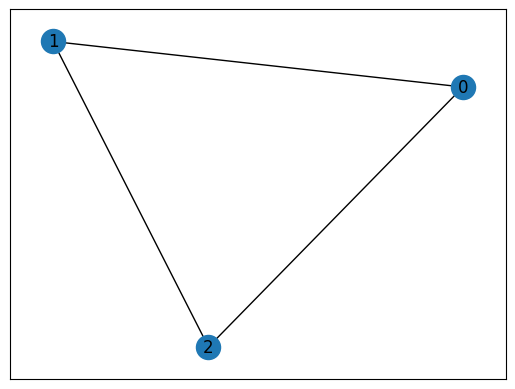

In [4]:
graph_examples = {
    "2_node_valid": [{
        "num_vertex": 2,
        "edges_list": [(0, 1)]
    }, "0001"],

    "2_node_invalid": [{
        "num_vertex": 2,
        "edges_list": [(0, 1)]
    }, "0101"],

    "3_node_valid": [{
        "num_vertex": 3,
        "edges_list": [(0, 1), (0, 2), (1, 2)]
    }, "000111"],

    "3_node_invalid": [{
        "num_vertex": 3,
        "edges_list": [(0, 1), (0, 2), (1, 2)]
    }, "010111"]
}

params, vertex_bits = graph_examples["3_node_valid"]
measure_all = True

graph_coloring = QuantumGraphColoring(**params)
graph_coloring.display_graph()
circuit = graph_coloring.initialize_quantum_circuit(measure_all=measure_all)

<IPython.core.display.Latex object>

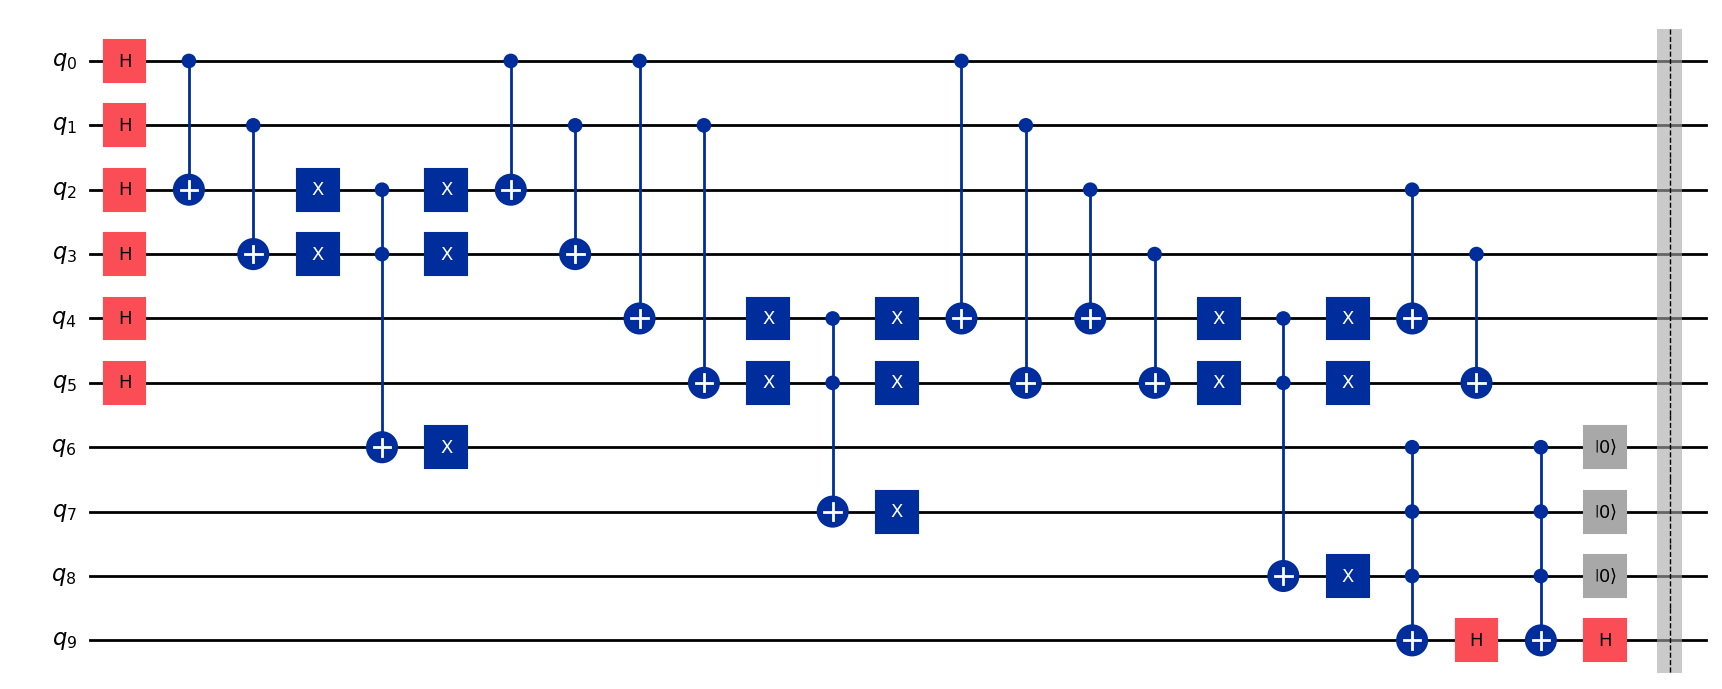

ValueError: axes don't match array

In [5]:
graph_oracle = GroverOracle(vertex_qubits=graph_coloring.vertex_qubits_tuple,
                            edges_list=graph_coloring.edges_list,
                            ancilla_qubits=graph_coloring.ancilla_qubits_list,
                            auxillary_qubit=graph_coloring.aux_qubit)

graph_oracle.test_oracle_circuit(vertex_bits="0000")

In [ ]:
grover_opt = GroverOptimization(vertex_qubits=graph_coloring.vertex_qubits_tuple,
                   auxillary_qubit=graph_coloring.aux_qubit, num_iterations=1)


Number of Iterations: 1


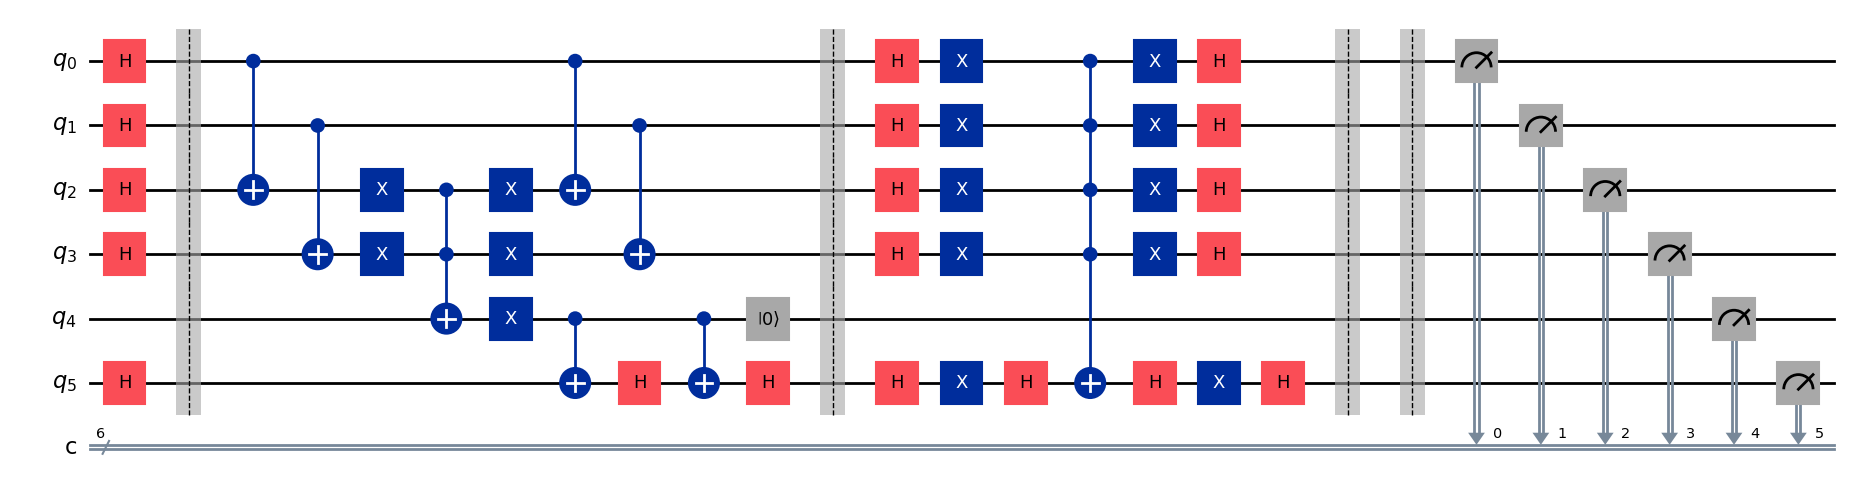

In [ ]:
grover_opt.apply_optimization(circuit=circuit, oracle=graph_oracle,
                              measure_all=measure_all)

In [ ]:
from qiskit_aer.backends import AerSimulator
from qiskit.visualization import plot_histogram

backend = AerSimulator()
job = backend.run(circuit, shots=2048)
counts = job.result().get_counts()

counts

{'001000': 82,
 '101010': 18,
 '000001': 80,
 '101001': 67,
 '000101': 11,
 '101110': 79,
 '001011': 77,
 '100010': 91,
 '000010': 93,
 '101011': 74,
 '000111': 68,
 '100100': 81,
 '001101': 62,
 '100011': 95,
 '001100': 88,
 '101111': 18,
 '000110': 75,
 '101101': 67,
 '000100': 76,
 '001010': 12,
 '100001': 73,
 '000011': 89,
 '101100': 82,
 '001001': 92,
 '100111': 88,
 '100000': 16,
 '001111': 10,
 '100110': 71,
 '101000': 92,
 '100101': 8,
 '001110': 93,
 '000000': 20}

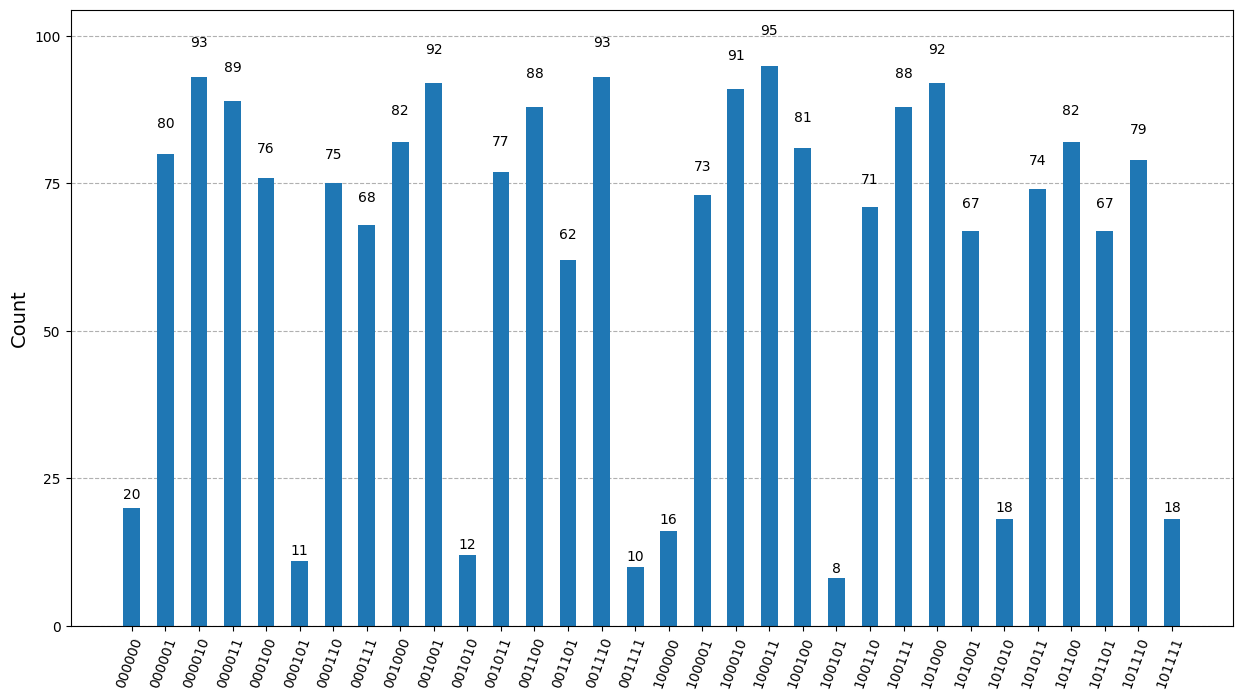

In [ ]:
plot_histogram(counts, figsize=(15, 8))

In [ ]:
from qiskit_aer.backends import AerSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display

def run_simulations(example_problem: list[dict | str]):
    params, _ = example_problem

    graph_coloring = QuantumGraphColoring(**params)
    circuit = graph_coloring.initialize_quantum_circuit(measure_all=False)

    graph_oracle = GroverOracle(vertex_qubits=graph_coloring.vertex_qubits_tuple,
                            edges_list=graph_coloring.edges_list,
                            ancilla_qubits=graph_coloring.ancilla_qubits_list,
                            auxillary_qubit=graph_coloring.aux_qubit)

    grover_opt = GroverOptimization(vertex_qubits=graph_coloring.vertex_qubits_tuple,
                   auxillary_qubit=graph_coloring.aux_qubit, num_iterations=None)

    for num_iter in range(1, grover_opt.num_interations + 1):
        grover_opt = GroverOptimization(vertex_qubits=graph_coloring.vertex_qubits_tuple,
                   auxillary_qubit=graph_coloring.aux_qubit, num_iterations=num_iter)

        grover_opt.apply_optimization(circuit=circuit, oracle=graph_oracle,
                                measure_all=False, draw=False)

        counts = AerSimulator().run(circuit, shots=2048).result().get_counts()
        display(plot_histogram(counts, figsize=(15, 4)))

Number of Vertices in the Graph: 2
Number of Edges in the Graph: 1
Number of Qubits for Quantum Circuit: 6
Auxillary Qubit Index: 5

Anilla Qubits:
	Node 0: Qubit(QuantumRegister(6, 'q'), 4)

Vertex Qubits:
	Node 0: (Qubit(QuantumRegister(6, 'q'), 0), Qubit(QuantumRegister(6, 'q'), 1))
	Node 1: (Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3))

Number of Iterations: 4

Number of Iterations: 1


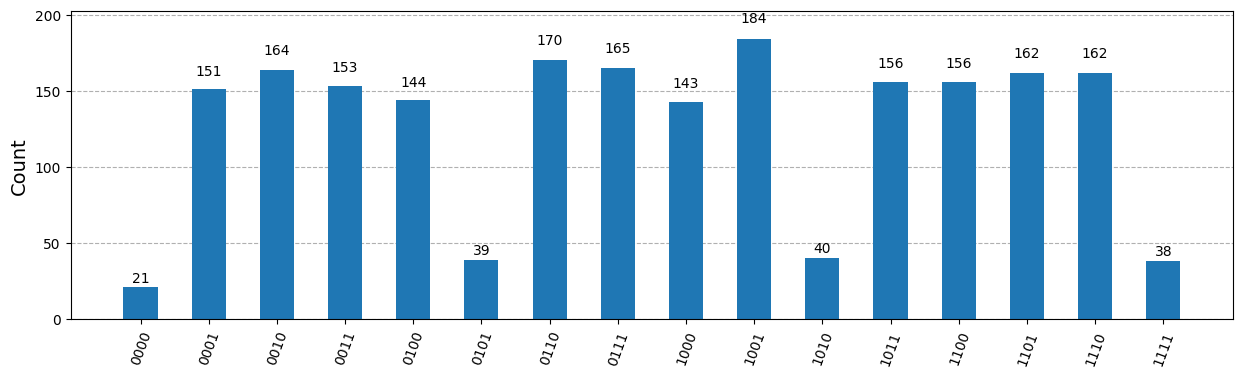


Number of Iterations: 2


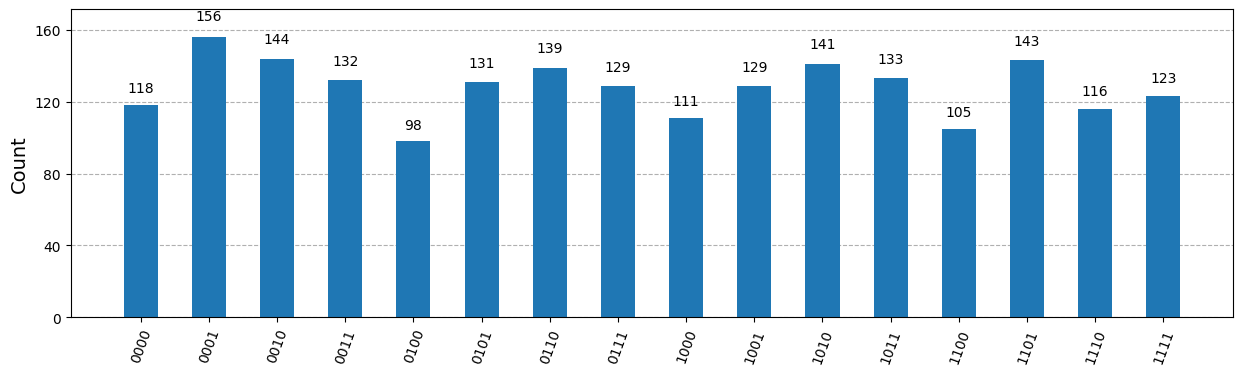


Number of Iterations: 3


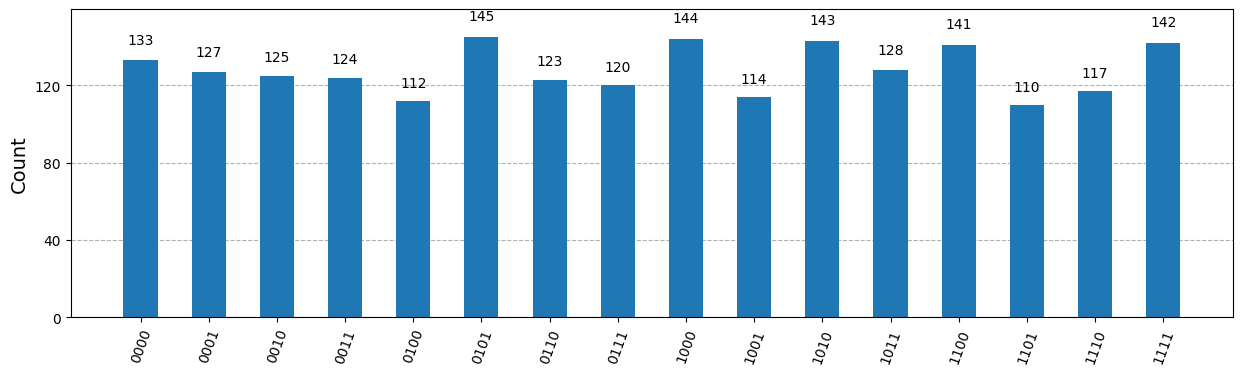


Number of Iterations: 4


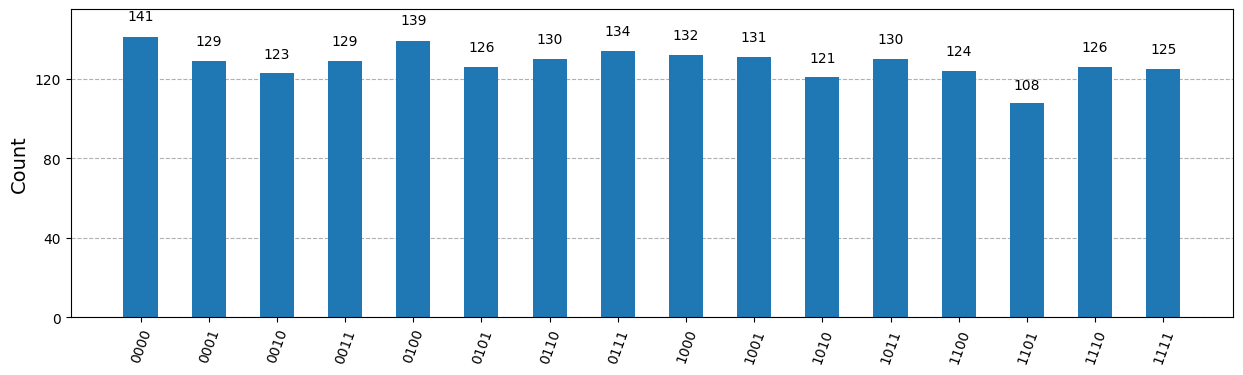

In [ ]:
run_simulations(example_problem=graph_examples["2_node_valid"])